In [1]:
import bayes3d as b
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
import matplotlib.pyplot as plt
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Generate Data

In [24]:
intrinsics = b.Intrinsics(
    height=1000,
    width=1000,
    fx=5000.0, fy=5000.0,
    cx=500.0, cy=500.0,
    near=1.0, far=10000.0
)

In [25]:
viz = b.o3d_viz.O3DVis(intrinsics)

model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
mesh_paths = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh_paths.append(mesh_path)
    meshes.append(b.mesh.load_mesh(mesh_path))

In [26]:
box_dims = jnp.array([
    b.utils.aabb(m.vertices)[0] for m in meshes
])
box_dims

Array([[102.289, 102.446, 140.144],
       [ 71.73 , 163.977, 213.486],
       [ 49.544,  94.048, 176.015],
       [ 67.854,  67.75 , 102.037],
       [ 97.15 ,  66.62 , 191.408],
       [ 85.51 ,  85.614,  33.511],
       [137.848, 128.791,  38.828],
       [ 89.355, 101.109,  30.12 ],
       [102.123,  60.322,  83.637],
       [108.888, 178.412,  36.67 ],
       [148.997, 144.769, 242.64 ],
       [102.406,  67.712, 250.64 ],
       [161.444, 161.113,  54.97 ],
       [116.966,  93.075,  81.384],
       [184.241, 187.434,  57.317],
       [103.951, 103.548, 205.89 ],
       [ 96.08 , 201.544,  15.716],
       [ 21.039, 120.845,  18.877],
       [119.956, 171.278,  39.15 ],
       [209.794, 164.36 ,  36.333],
       [ 52.63 ,  77.842,  51.131]], dtype=float32)

In [27]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2000.0, 1200.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
key = jax.random.PRNGKey(200)

In [28]:
key = jax.random.split(key)[1]
indices = jax.random.choice(key,21,shape=(3,))
contact_params = jax.random.uniform(
    key,
    shape=(3,3,),
    minval=jnp.array([-200.0,-200.0, 0.0]),
    maxval=jnp.array([200.0, 200.0, 2*jnp.pi])
)
faces = jnp.array([3,3,3])
dims_child = box_dims[indices]
poses = contact_plane @ b.scene_graph.relative_pose_from_edge_parallel_jit(
    contact_params, faces, dims_child
)
viz.clear()
viz.render.scene.set_lighting(viz.render.scene.LightingProfile.NO_SHADOWS, (0, 0, 0))
for i in range(len(indices)):
    viz.make_mesh_from_file(mesh_paths[indices[i]], poses[i])
rgbd = viz.capture_image(intrinsics, jnp.eye(4))
b.get_rgb_image(rgbd.rgb)

: 

: 

# Setup Renderer

In [8]:
renderer = b.Renderer(intrinsics)
model_dir = os.path.join(j.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path)
SCALING_FACTOR = 3

table_params = data["table_params"]
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

: 

: 

# Visualize Observed RGB and Depth

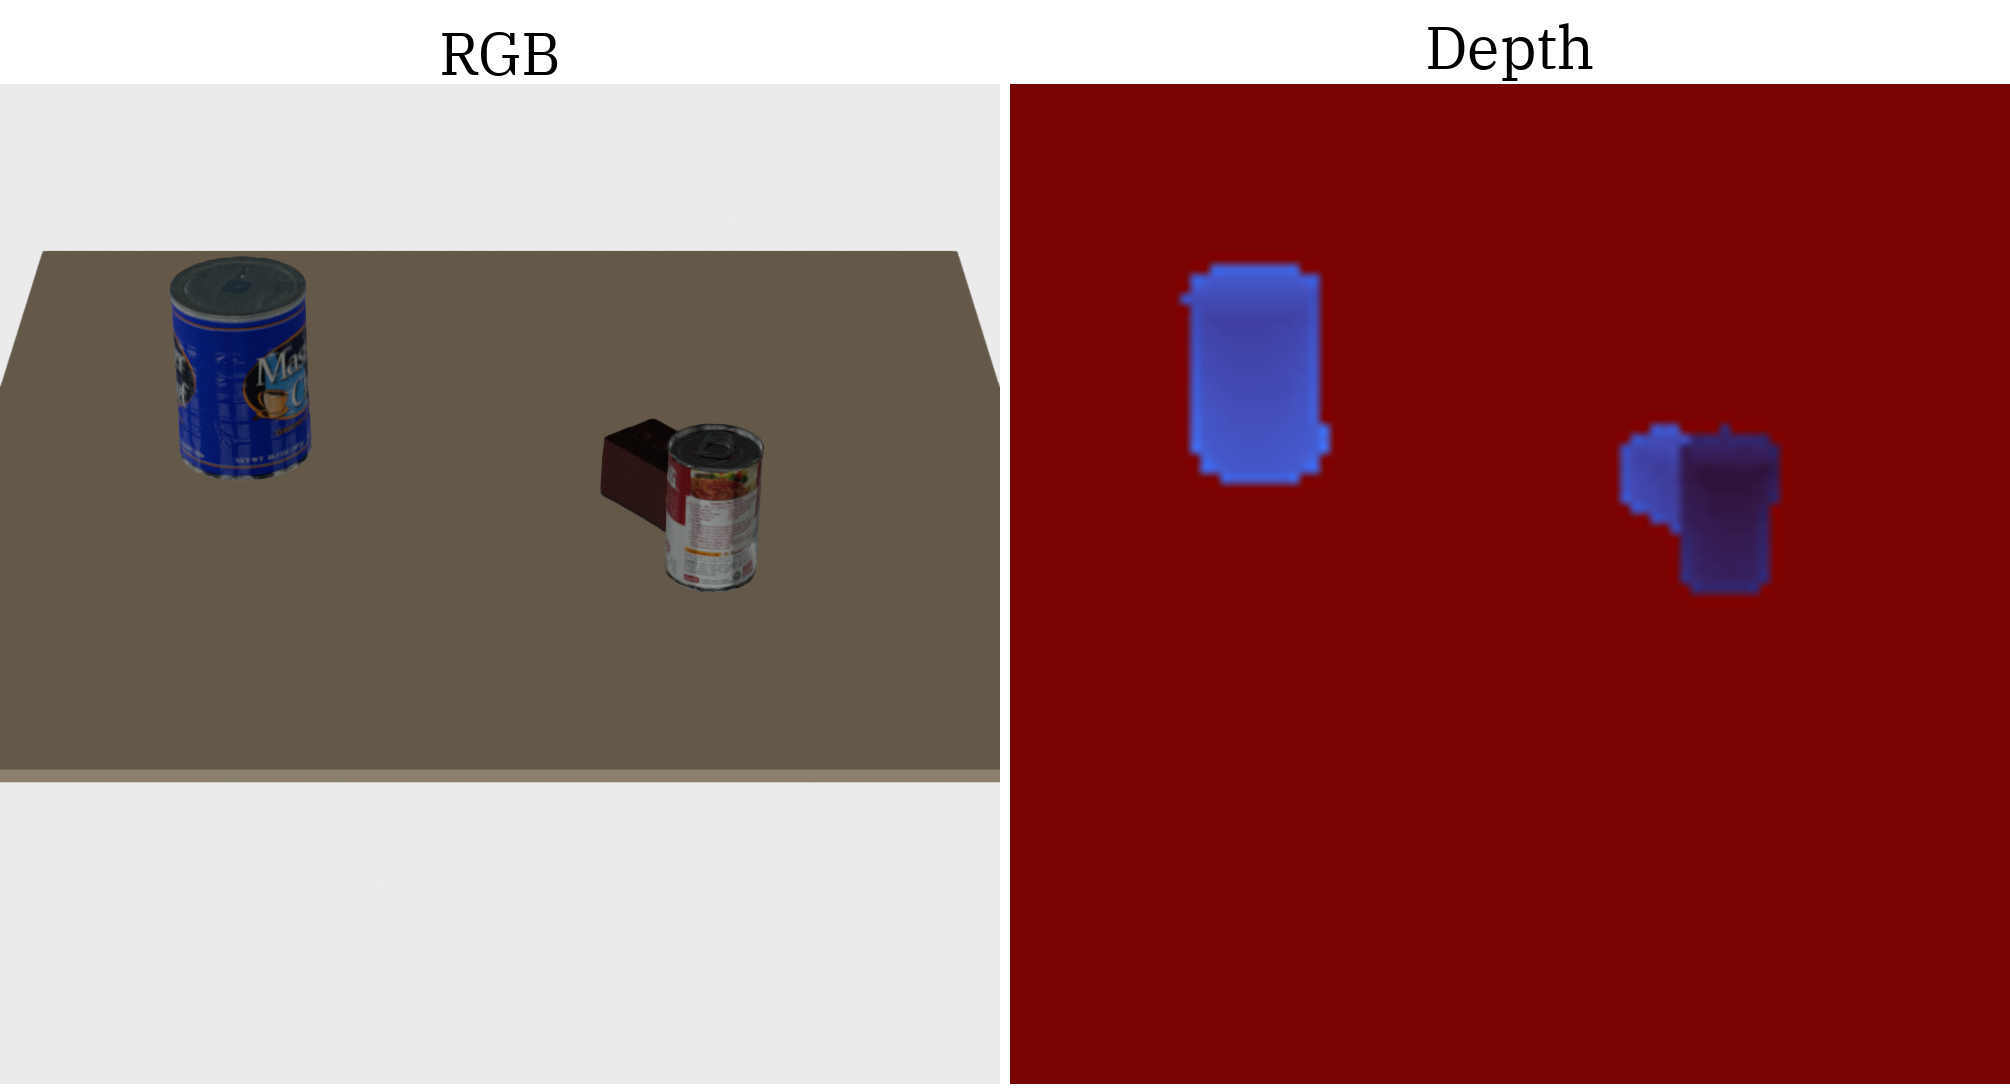

In [4]:
observed_point_cloud_image = renderer.render_multiobject(
    jnp.concatenate([poses]),
    jnp.concatenate([indices])
)

j.multi_panel(
    [j.get_rgb_image(rgb), j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2],max=4000.0), 10)],
    labels=["RGB", "Depth"], label_fontsize=60
)

# Set Gridding Parameters for Enumeration

In [5]:
VARIANCE_GRID = jnp.array([200.0, 100.0, 30.0, 5.0, 1.0]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.3, 4)
OUTLIER_VOLUME = 1000.0**3

grid_params = [
    (200.0, jnp.pi, (11,11,5)), (20.0, jnp.pi/5, (11,11,5)), (2.0, jnp.pi/5, (11,11,5)),
    (0.0, jnp.pi, (1,1,7*7)), (0.5, jnp.pi/5/5, (11,11,5))
]
contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


In [6]:
VARIANCES_FOR_OBJECTS = jnp.array([0.5])
object_poses, object_ids = jnp.zeros((0,1,4,4)), []

# Enumerate over Object Type, Pose, Noise Level

In [12]:
all_hypotheses = []
for obj_id in tqdm(range(21)):
#     print("Object Id : ", obj_id)
    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param
        
        potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
            contact_plane
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(VARIANCES_FOR_OBJECTS[None,:], (VARIANCE_GRID.shape[0], 1)),VARIANCE_GRID])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
            observed_point_cloud_image, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1],
            POTENTIAL_R, OUTLIER_GRID, OUTLIER_VOLUME,
            3
        )
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]

    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_GRID[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print(j.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]



100%|██████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.06it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[20  5 17  0  3  6  7  8  9 13 16 18 19 12  4  2 14 11 15  1 10]
Best
[0.5 1. ] 0.01 20


[0.5 1. ]


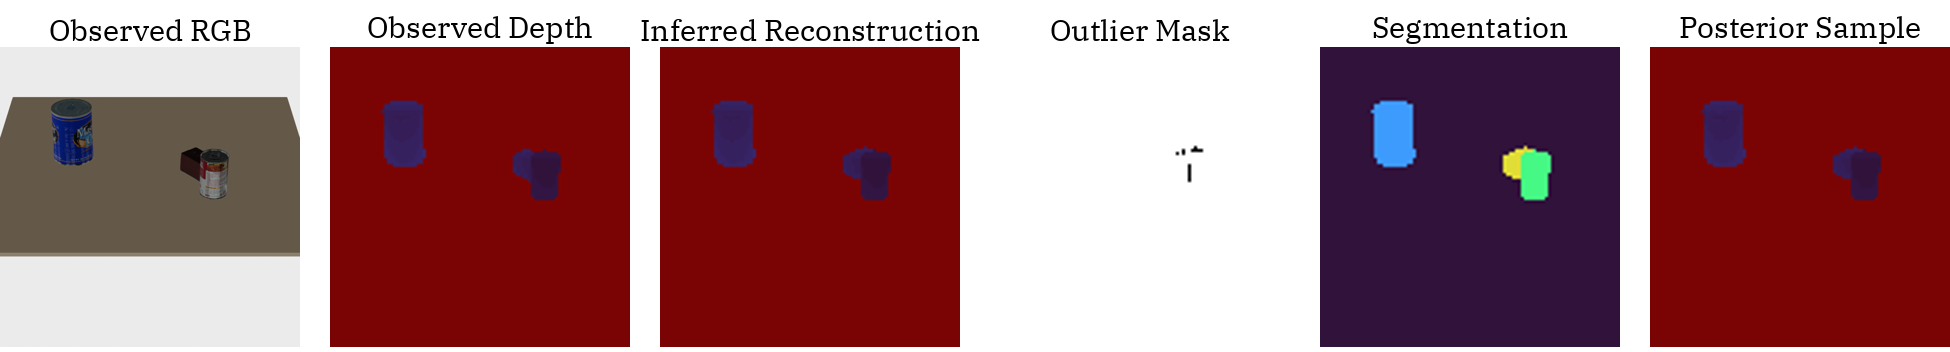

In [13]:
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)
inliers = (
    (jnp.log(1.0 - best_outlier_prob)  + j.threedp3_likelihood_multi_r_per_pixel_jit(
        observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r, 0.0, 1.0,3
    ))
        >
    jnp.log(best_outlier_prob / OUTLIER_VOLUME)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(12)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)


viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:d} : {:0.3f}".format(idx, i[0].item()) for (idx,i) in enumerate(all_hypotheses)]
)
viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/10),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2